In [4]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd

In [12]:
df = pd.read_csv('tumors.csv')
df.head(12)

,leukocyte_count,blood_pressure,tumor_class
0,13.472969,15.250393,malignant
1,10.805510,14.109676,malignant
2,13.834053,15.793920,malignant
3,9.572811,17.873286,malignant
4,7.633667,16.598559,malignant
5,12.795534,16.021330,malignant
6,12.885377,15.402248,malignant
7,16.048327,16.059701,malignant
8,13.486377,14.691901,malignant
9,9.438947,17.223709,malignant


In [13]:
X = df[['leukocyte_count', 'blood_pressure']].values
y = df['tumor_class'].values

In [16]:
from sklearn.preprocessing import LabelEncoder

In [20]:
tumor_encoder = LabelEncoder()
tumor_encoder.fit(y)

LabelEncoder()

In [23]:
y = tumor_encoder.transform(y)

In [35]:
tumor_encoder.classes_.tolist()

['benign', 'malignant']

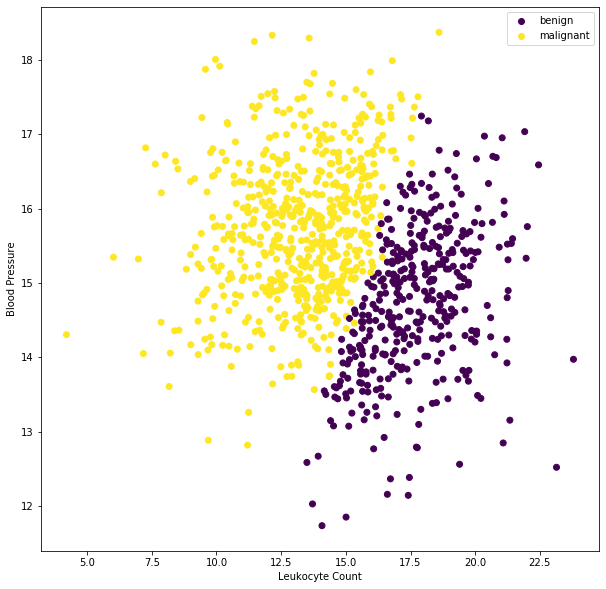

In [37]:
plt.figure(figsize=(10, 10))
pts = plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')

plt.xlabel('Leukocyte Count')
plt.ylabel('Blood Pressure')
plt.legend(handles=pts.legend_elements()[0], labels=tumor_encoder.classes_.tolist(), scatterpoints=1)
plt.show()

# Preprocessing

In [105]:
import ml_utils
import importlib
importlib.reload(ml_utils)

<module 'ml_utils' from '/home/djn/Notes/CSNotes/ML/tf/tf/ml_utils.py'>

In [57]:
(x_train, y_train), (x_val, y_val), (x_test, y_test) = ml_utils.train_validate_test_split(X, y, validate_size=0.15, test_size=0.15, stratify=True)

In [59]:
[(x_train.shape, y_train.shape), (x_val.shape, y_val.shape), (x_test.shape, y_test.shape)]

[((700, 2), (700,)), ((150, 2), (150,)), ((150, 2), (150,))]

In [66]:
import collections
counts = collections.Counter(y_train)
class_weights = {_class: 1.0 / cnt for _class, cnt in counts.items()}
print(counts, '\n', class_weights)

Counter({1: 427, 0: 273}) 
 {0: 0.003663003663003663, 1: 0.00234192037470726}


# Train

In [67]:
from sklearn.preprocessing import StandardScaler
x_scaler = StandardScaler()
x_train = x_scaler.fit_transform(x_train)

x_val = x_scaler.transform(x_val)
x_test = x_scaler.transform(x_test)

In [71]:
print (f"X_train[0]: mean: {np.mean(x_train[:, 0], axis=0):.1f}, std: {np.std(x_train[:, 0], axis=0):.1f}")
print (f"X_train[1]: mean: {np.mean(x_train[:, 1], axis=0):.1f}, std: {np.std(x_train[:, 1], axis=0):.1f}")
print (f"X_val[0]: mean: {np.mean(x_val[:, 0], axis=0):.1f}, std: {np.std(x_val[:, 0], axis=0):.1f}")
print (f"X_val[1]: mean: {np.mean(x_val[:, 1], axis=0):.1f}, std: {np.std(x_val[:, 1], axis=0):.1f}")
print (f"X_test[0]: mean: {np.mean(x_test[:, 0], axis=0):.1f}, std: {np.std(x_test[:, 0], axis=0):.1f}")
print (f"X_test[1]: mean: {np.mean(x_test[:, 1], axis=0):.1f}, std: {np.std(x_test[:, 1], axis=0):.1f}")

X_train[0]: mean: 0.0, std: 1.0
X_train[1]: mean: 0.0, std: 1.0
X_val[0]: mean: 0.0, std: 1.0
X_val[1]: mean: -0.1, std: 1.0
X_test[0]: mean: 0.0, std: 0.9
X_test[1]: mean: -0.1, std: 0.9


In [72]:
import time
tf.set_random_seed(int(time.time()))

In [73]:
from keras import models, layers, metrics, losses, utils, optimizers

In [76]:
class LogisticRegressKeras(models.Model):
    def __init__(self, n_classes):
        super().__init__(name='LogisticRegressKeras')
        self.fc = layers.Dense(units=n_classes, activation='softmax', name='')

    def call(self, inputs):
        probs = self.fc(inputs)

        return probs

In [77]:
log_reg = LogisticRegressKeras(2)

In [78]:
xent_cost = losses.sparse_categorical_crossentropy
adam_opt = optimizers.Adam(lr=1e-2)
metrics = [metrics.sparse_categorical_accuracy]

In [79]:
log_reg.compile(loss=xent_cost, optimizer=adam_opt, metrics=metrics)

In [87]:
pred_test = np.argmax(log_reg.predict(x_test), axis=-1)

In [97]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, pred_test)

0.98

In [100]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_test))

precision    recall  f1-score   support

           0       0.95      1.00      0.97        58
           1       1.00      0.97      0.98        92

   micro avg       0.98      0.98      0.98       150
   macro avg       0.98      0.98      0.98       150
weighted avg       0.98      0.98      0.98       150



In [86]:
log_reg.fit(x_train, y_train, batch_size=50, epochs=40, verbose=1, validation_data=(x_val, y_val), class_weight=class_weights)

Train on 700 samples, validate on 150 samples
Epoch 1/40
700/700 [==============================] - 1s 1ms/step - loss: 0.0042 - sparse_categorical_accuracy: 0.1229 - val_loss: 1.3434 - val_sparse_categorical_accuracy: 0.1200
Epoch 2/40
700/700 [==============================] - 0s 91us/step - loss: 0.0034 - sparse_categorical_accuracy: 0.1643 - val_loss: 1.1250 - val_sparse_categorical_accuracy: 0.1733
Epoch 3/40
700/700 [==============================] - 0s 87us/step - loss: 0.0029 - sparse_categorical_accuracy: 0.2700 - val_loss: 0.9435 - val_sparse_categorical_accuracy: 0.2933
Epoch 4/40
700/700 [==============================] - 0s 85us/step - loss: 0.0024 - sparse_categorical_accuracy: 0.3986 - val_loss: 0.7987 - val_sparse_categorical_accuracy: 0.4067
Epoch 5/40
700/700 [==============================] - 0s 88us/step - loss: 0.0020 - sparse_categorical_accuracy: 0.5243 - val_loss: 0.6819 - val_sparse_categorical_accuracy: 0.5333
Epoch 6/40
700/700 [==============================

In [89]:
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [90]:
def plot_confusion_matrix(y_true, y_pred, classes, cmap=plt.cm.Blues):
    """Plot a confusion matrix using ground truth and predictions."""
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    #  Figure
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)

    # Axis
    plt.title("Confusion matrix")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    ax.set_xticklabels([''] + classes)
    ax.set_yticklabels([''] + classes)
    ax.xaxis.set_label_position('bottom') 
    ax.xaxis.tick_bottom()

    # Values
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]:d} ({cm_norm[i, j]*100:.1f}%)",
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    # Display
    plt.show()

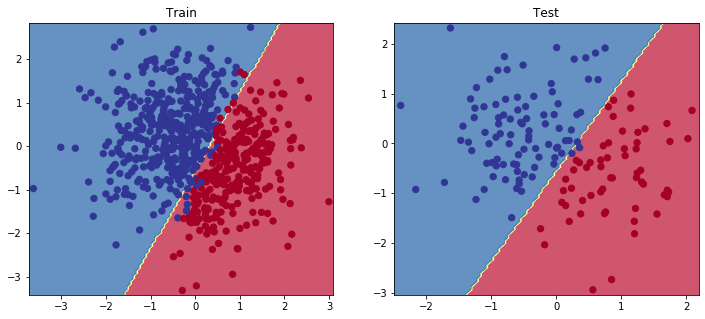

In [106]:
# Visualize the decision boundary
from ml_utils import plot_multiclass_decision_boundary
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_multiclass_decision_boundary(model=log_reg, X=x_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_multiclass_decision_boundary(model=log_reg, X=x_test, y=y_test)
plt.show()